# Boxplots

## Script setup

In [1]:
# Third-party and standard modules
from typing import Dict, Hashable
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from importlib import reload
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# User-defined modules.
# The reload() function is needed to update modules after
# changes are made to their files.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is needed to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

In [2]:
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries

## Script parameters

The following values are this script's parameters.

In [3]:
#filepath = './cisco_wifi_data_until_20190513.csv'
filepath = './wifi_data_until_20190204.csv'
timezone = pytz.timezone('US/Pacific')
'''buildings = [
                'SCC', 'HAHN', 'CROOKSHANK', 'THATHCHER', 'CLARK',
                'CARNEGIE', 'MASON', 'PEARSON', 'ALEXANDER', 'ITB'
]
'''
buildings = [
                'ALEXANDER'
]

#Fall Semester 
start_date = '2018-11-21' #None
end_date = '2018-11-23' #None


boxplot_hourly_average = True
holiday_analysis = True

## Data Processing

In [4]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [5]:
if start_date is not None: 
    if end_date is None:
        occ = occ.loc[start_date:]
    else:
        occ = occ.loc[start_date:end_date]
else:
    if end_date is not None:
        occ = occ.loc[:end_date]

In [6]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))
'''
# We must assume that intervening na-values are 0's.
occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)
'''

"\n# We must assume that intervening na-values are 0's.\nocc = dfm.fill_intervening_nas(\n    occ, inplace=True, fill_val=0\n)\n"

In [7]:
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [8]:
print('buildings not found: {}'.format(set(buildings) - set(occ_bybuild.groups.keys())))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())

buildings not found: set()


## Boxplots

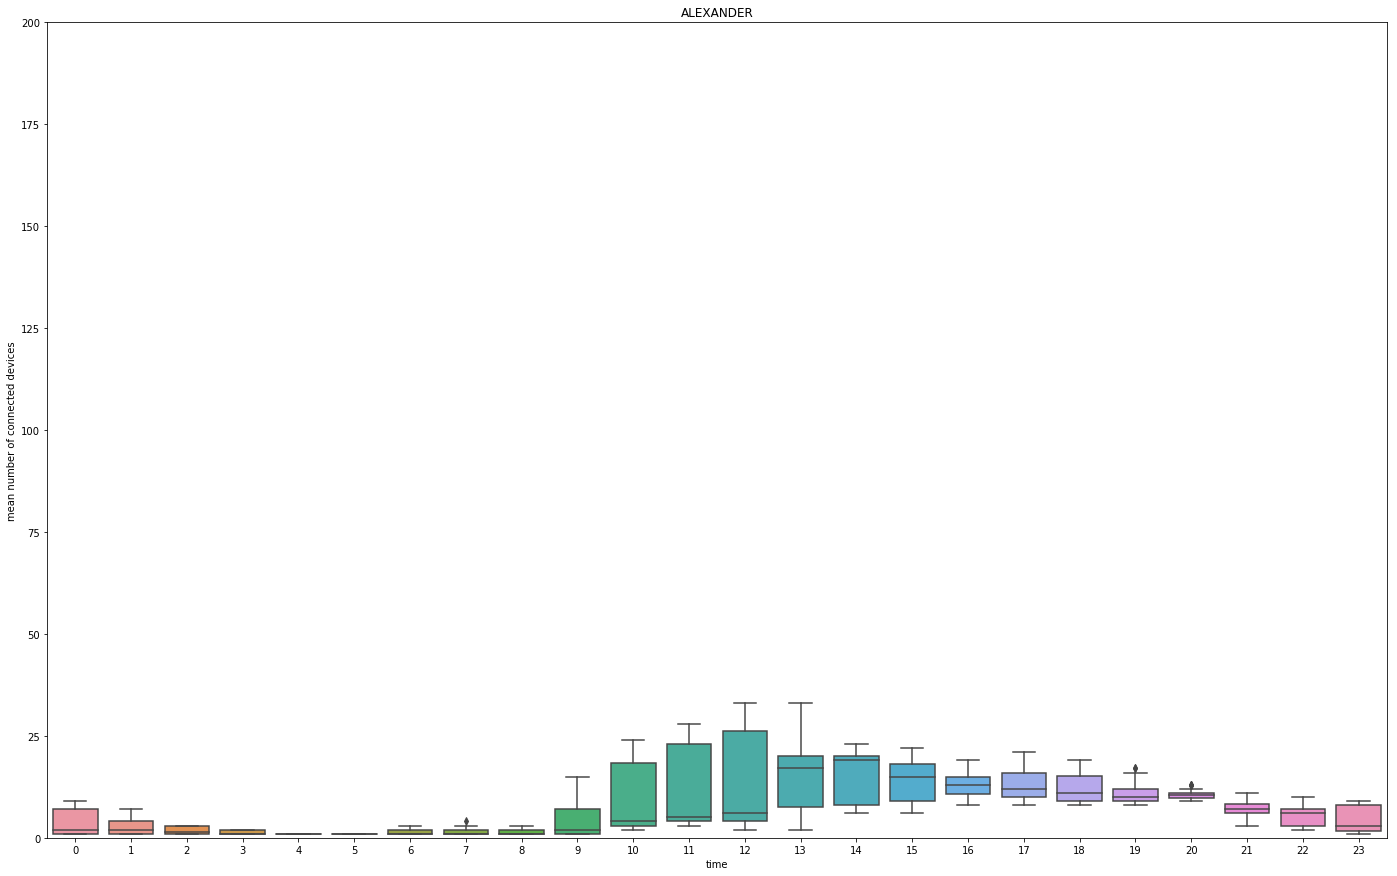

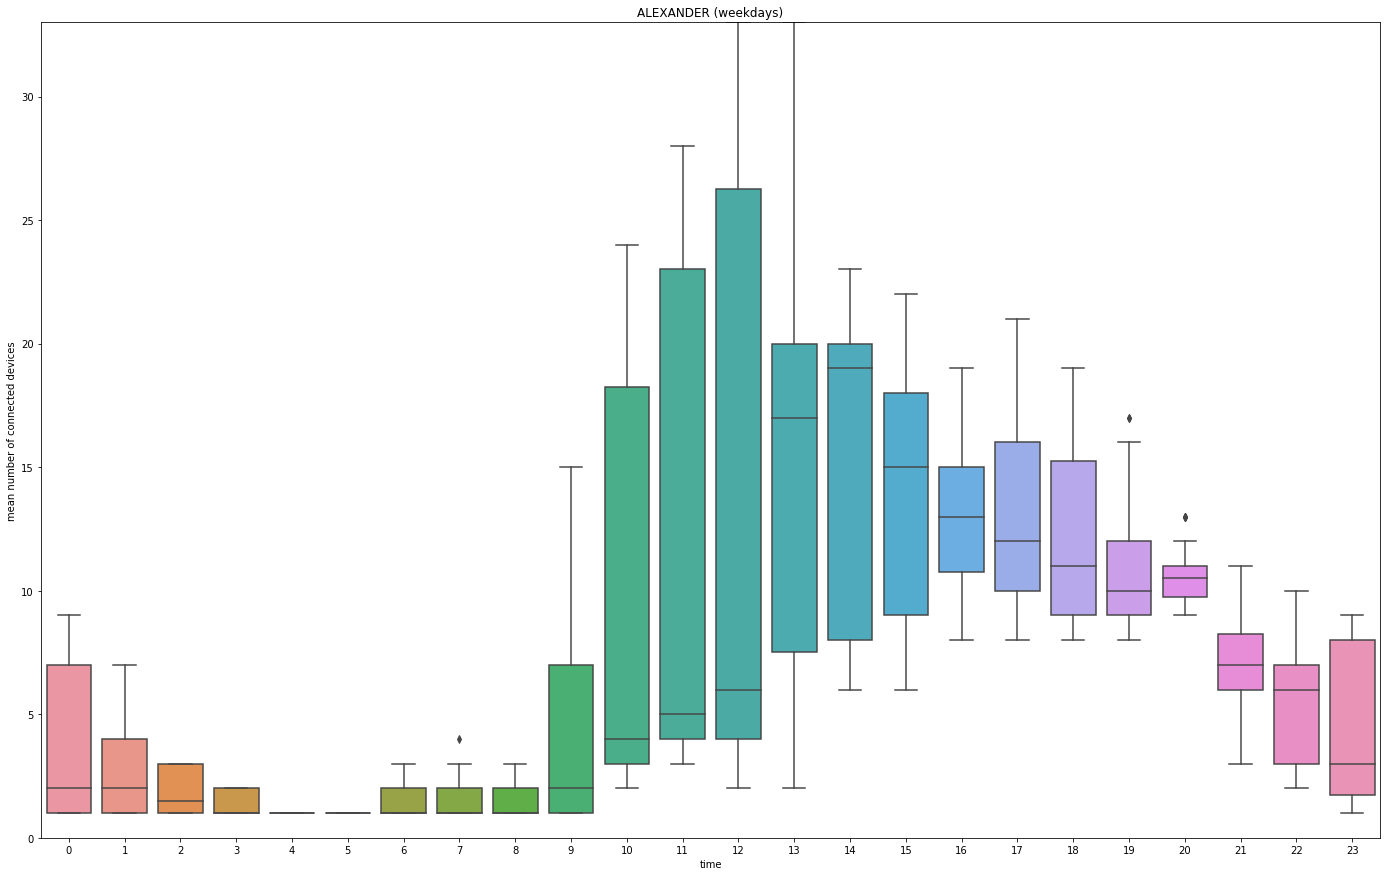

In [9]:
if(boxplot_hourly_average == True):
    means_by_building: Dict[Hashable, pd.DataFrame] = {}
    maxmean = float('-inf')
    for build in buildings:
        means_by_building[build] = dfm.row_means(occ_bybuild.get_group(build))
        newmax = means_by_building[build].max()
        newmin = means_by_building[build].min()
        maxmean = newmax if newmax > maxmean else maxmean
    #print(maxmean)

    for build in buildings:
        mean_occ: pd.DataFrame = dfm.row_means(occ_bybuild.get_group(build))

        fig, ax = plt.subplots(figsize=(24, 15))
        ax.set_title(build)
        ax.set_xlabel('hour of the day')
        ax.set_ylabel('mean number of connected devices')
        ax.set_ylim(0, 200)

        seaborn.boxplot(
            # The hours (a number [0,23]) for each row.
            x=mean_occ.index.hour,
            # The total occupancy at that hour.
            y=mean_occ,
            ax=ax
        )


        fig, ax = plt.subplots(figsize=(24, 15))
        ax.set_title(build + ' (weekdays)')
        ax.set_xlabel('hour of the day')
        ax.set_ylabel('mean number of connected devices')
        ax.set_ylim(0, maxmean)

        wkdays = mean_occ.loc[mean_occ.index.dayofweek<5].copy()

        seaborn.boxplot(
            # The hours (a number [0,23]) for each row.
            x=wkdays.index.hour,
            # The total occupancy at that hour.
            y=wkdays,
            ax=ax
        )
        fig.savefig('./{}.png'.format(build))
        '''
        fig, ax = plt.subplots(figsize=(24, 15))
        ax.set_title(build + ' (weekends)')
        ax.set_xlabel('hour of the day')
        ax.set_ylabel('mean number of connected devices')
        ax.set_ylim(0, maxmean)

        wkends = mean_occ.loc[mean_occ.index.dayofweek>=5].copy()

        seaborn.boxplot(
            # The hours (a number [0,23]) for each row.
            x=wkends.index.hour,
            # The total occupancy at that hour.
            y=wkends,
            ax=ax
        )
        '''

## Holidays

In [10]:
if (holiday_analysis == True):
    holi_caldr = calendar()
    holidays = holi_caldr.holidays(start = start_date, end = end_date)

    display(holidays)
    holiday_ts = pd.to_datetime(holidays)

    truncated_time = occ.index.normalize()
    occ['time_no_timezone'] = truncated_time.tz_localize(None)
    occ['isHoliday'] = occ['time_no_timezone'].isin(holiday_ts)

    #print(occ['isHoliday'].any())
    #print(type(occ.index))
    display(occ)

DatetimeIndex(['2018-11-22'], dtype='datetime64[ns]', freq=None)

,POM-ALEXANDER133-AP205-12,POM-ALEXANDER-SR-AP205-5,POM-ALEXANDER-SE-AP275-1,POM-ALEXANDER235B-AP205-16,POM-ALEXANDER241-AP205-17,POM-ALEXANDER118-AP205-24,POM-ALEXANDER122A-AP205-23,POM-ALEXANDER101-AP205-10,POM-ALEXANDER134-AP205-2,POM-ALEXANDER204-AP205-17,...,POM-ALEXANDER244-AP205-13,POM-ALEXANDER139-AP205-3,POM-ALEXANDER208-AP205-8,POM-ALEXANDER215-AP205-15,POM-ALEXANDER1C09-AP205-2,POM-ALEXANDER224-AP205-3,POM-ALEXANDER217-AP205-20,POM-ALEXANDER251-AP205-13,time_no_timezone,isHoliday
time,,,,,,,,,,,,,,,,,,,,,
2018-11-21 00:00:05-08:00,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:05:05-08:00,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:10:05-08:00,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:15:05-08:00,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:20:05-08:00,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:25:17-08:00,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:30:05-08:00,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:35:15-08:00,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False
2018-11-21 00:40:05-08:00,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-21,False


In [11]:
#occ.grouby('isHoliday').size()
#occ['2018-11-22']

22.0


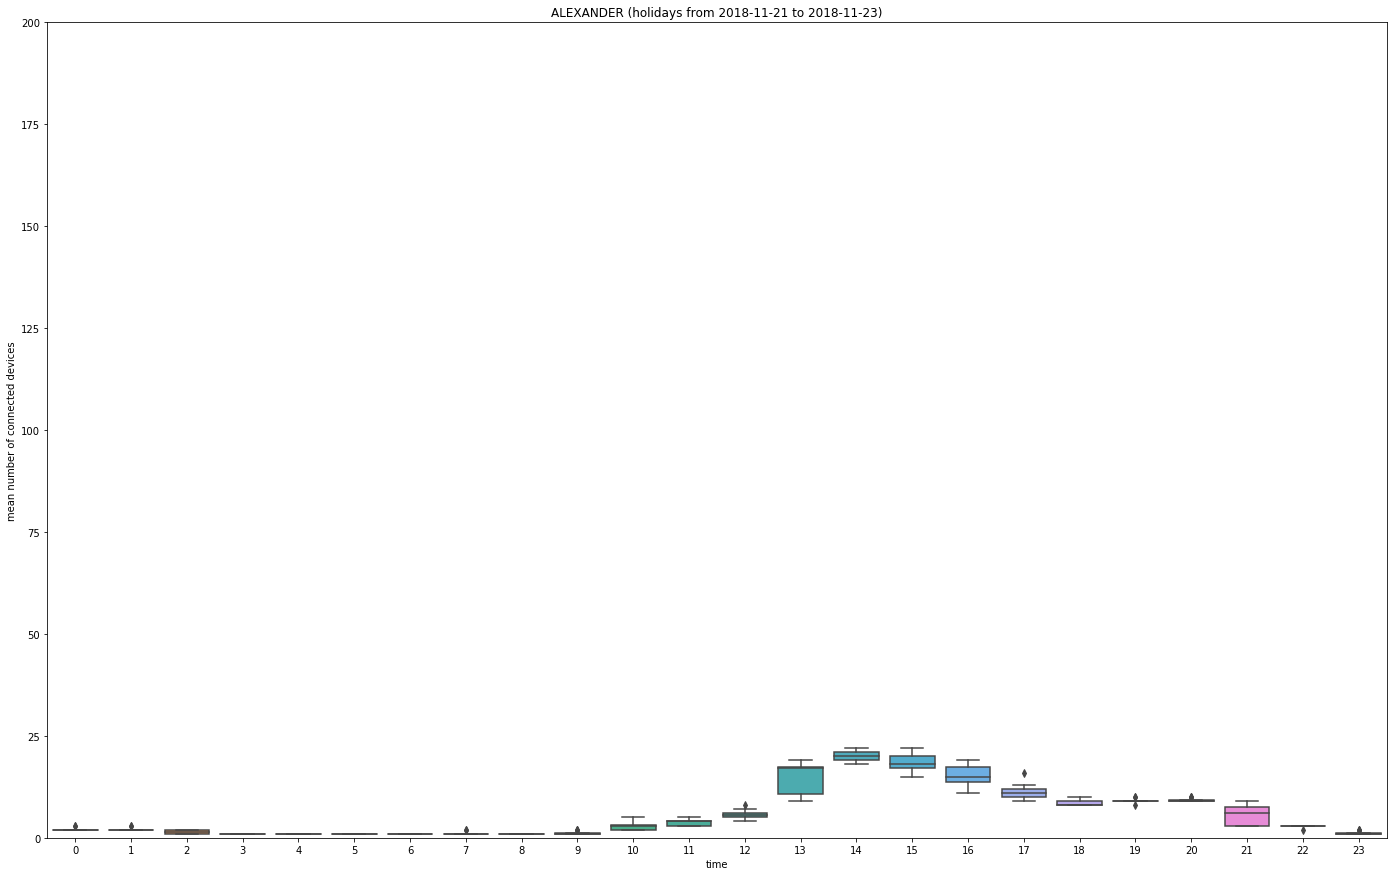

In [12]:
if (holiday_analysis == True):
    holiday_occ = occ.loc[occ['isHoliday'] == True]
    #display(occ)
    holiday_occ = holiday_occ.drop(['time_no_timezone', 'isHoliday'], axis =1)
    occ_holiday_bybuild = holiday_occ.groupby(
        by=schema.col_to_building, axis=1
    )

    means_by_building: Dict[Hashable, pd.DataFrame] = {}
    maxmean = float('-inf')
    for build in buildings:
        means_by_building[build] = dfm.row_means(occ_holiday_bybuild.get_group(build))
        newmax = means_by_building[build].max()
        newmin = means_by_building[build].min()
        maxmean = newmax if newmax > maxmean else maxmean
    print(maxmean)

    for build in buildings:
        mean_occ_holiday: pd.DataFrame = dfm.row_means(occ_holiday_bybuild.get_group(build))

        fig, ax = plt.subplots(figsize=(24, 15))
        ax.set_title(build + ' (holidays from ' + start_date + ' to ' + end_date +')')
        ax.set_xlabel('hour of the day')
        ax.set_ylabel('mean number of connected devices')
        ax.set_ylim(0, 200)

        seaborn.boxplot(
            # The hours (a number [0,23]) for each row.
            x=mean_occ_holiday.index.hour,
            # The total occupancy at that hour.
            y=mean_occ_holiday,
            ax=ax
        )
  

In [13]:
#holiday_occ